In [1]:
!pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 69.0 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import set_config
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

set_config(display="text")  # displays text representation of estimators
sns.set_style("whitegrid")

In [3]:
from google.colab import files

In [4]:
X_full = pd.read_csv('/content/METABRIC_RNA_Mutation.csv', low_memory=False)

In [5]:
clinical_df = X_full.iloc[:, :31]

In [6]:
clinical_df_inverted = clinical_df.copy()
clinical_df_inverted['overall_survival'] = clinical_df_inverted['overall_survival'].replace([0,1],[1,0])

In [7]:
KM_df = clinical_df_inverted.copy()

In [8]:
KM_df[['overall_survival']] = KM_df[['overall_survival']].astype(bool)

In [9]:
KM_df.drop(['patient_id', 'cohort', 'cancer_type', 'oncotree_code', 'death_from_cancer'], axis=1, inplace=True)

In [10]:
X = KM_df.copy()
X.drop(['overall_survival', 'overall_survival_months'], axis=1, inplace=True)

In [11]:
y = KM_df.copy()
y.drop(['age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status',
       'neoplasm_histologic_grade', 'her2_status_measured_by_snp6',
       'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index','pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage'], axis=1, inplace=True)

In [12]:
y_rear = y[['overall_survival', 'overall_survival_months']]

In [13]:
new_y = y_rear[['overall_survival', 'overall_survival_months']].to_numpy()

In [14]:
#Делаем структурированный массив
dt=dtype=[('overall_survival', '?'), ('overall_survival_months', '<f8')]

#Structured array
struct_y = np.array([tuple(row) for row in new_y], dtype=dt)
struct_y

array([(False, 140.5       ), (False,  84.63333333),
       ( True, 163.7       ), ..., ( True, 175.9666667 ),
       ( True,  86.23333333), ( True, 201.9       )],
      dtype=[('overall_survival', '?'), ('overall_survival_months', '<f8')])

In [15]:
X_cat = encode_categorical(X)
X_cat = X_cat.fillna(X_cat.median())

/usr/local/lib/python3.10/dist-packages/sksurv/column.py:137: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  columns_to_encode = {nam for nam, s in table.iteritems() if _is_categorical_or_object(s)}
/usr/local/lib/python3.10/dist-packages/sksurv/column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


In [16]:
n_censored = struct_y.shape[0] - struct_y["overall_survival"].sum()
print("%.1f%% of records are censored" % (n_censored / struct_y.shape[0] * 100))

42.1% of records are censored


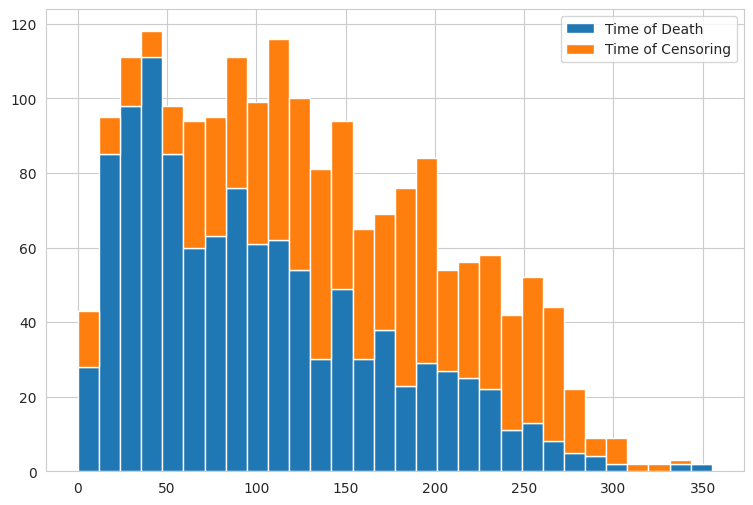

In [17]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((struct_y["overall_survival_months"][struct_y["overall_survival"]],
                               struct_y["overall_survival_months"][~struct_y["overall_survival"]]),
                              bins=30, stacked=True)
_ = plt.legend(patches, ["Time of Death", "Time of Censoring"])

In [18]:
estimator = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)

In [19]:
def score_survival_model(model, X_cat, struct_y):
    prediction = model.predict(X_cat)
    result = concordance_index_censored(struct_y['overall_survival'], struct_y['overall_survival_months'], prediction)
    return result[0]

In [20]:
param_grid = {'alpha': 2. ** np.arange(-12, 13, 2)}
cv = ShuffleSplit(n_splits=100, test_size=0.5, random_state=0)
gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model,
                   n_jobs=1, refit=False,
                   cv=cv)

In [21]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
gcv = gcv.fit(X_cat, struct_y)

In [22]:
round(gcv.best_score_, 3), gcv.best_params_

(0.682, {'alpha': 0.000244140625})

In [23]:
def plot_performance(gcv):
    n_splits = gcv.cv.n_splits
    cv_scores = {"alpha": [], "test_score": [], "split": []}
    order = []
    for i, params in enumerate(gcv.cv_results_["params"]):
        name = "%.5f" % params["alpha"]
        order.append(name)
        for j in range(n_splits):
            vs = gcv.cv_results_["split%d_test_score" % j][i]
            cv_scores["alpha"].append(name)
            cv_scores["test_score"].append(vs)
            cv_scores["split"].append(j)
    df = pd.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x="alpha", y="test_score", data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation("vertical")

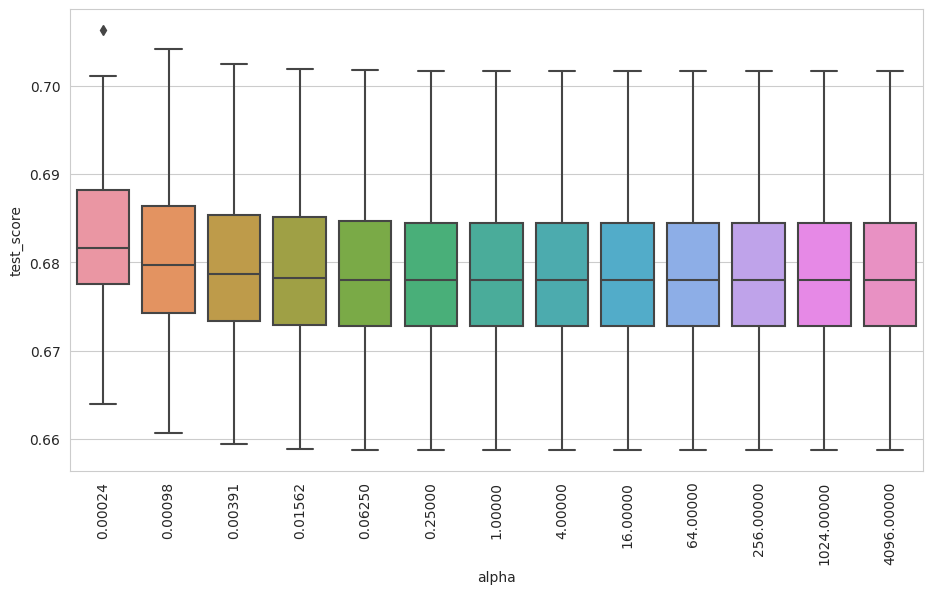

In [24]:
plot_performance(gcv)

In [25]:
# классификация
estimator.set_params(**gcv.best_params_)
estimator.fit(X_cat, struct_y)

FastSurvivalSVM(alpha=0.000244140625, max_iter=1000, optimizer='avltree',
                random_state=0, tol=1e-05)

In [26]:
pred = estimator.predict(X_cat.iloc[9:11])
print(np.round(pred, 3))
print(y[9:11])

[1.624 1.448]
    overall_survival_months  overall_survival
9                 36.266667              True
10               132.033333              True


In [27]:
#регрессия - но что-то пошло не так, с ошибкой не получается разобраться
ref_estimator = FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=0)
ref_estimator.fit(X_cat, struct_y)

cindex = concordance_index_censored(
    struct_y['overall_survival'],
    struct_y['overall_survival_months'],
    -ref_estimator.predict(X_cat),  # flip sign to obtain risk scores
)
print(round(cindex[0], 3))

ValueError: ignored

In [ ]:
pred = ref_estimator.predict(X_cat.iloc[9:11])
print(np.round(pred, 3))

In [ ]:
#Kernel survival SVM - к сожалению, занимает большое количество времени, решено воздержаться от продолжения
#from sksurv.kernels import clinical_kernel
#from sksurv.svm import FastKernelSurvivalSVM

In [ ]:
#kernel_matrix = clinical_kernel(X_cat)

In [ ]:
#kssvm = FastKernelSurvivalSVM(optimizer="rbtree", kernel="precomputed", random_state=0)

#kgcv = GridSearchCV(kssvm, param_grid, scoring=score_survival_model,
#                   n_jobs=1, refit=False,
#                   cv=cv)

In [ ]:
#kgcv = kgcv.fit(kernel_matrix, struct_y)